In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from functools import partial
import random as rand

In [3]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

IndexError: list index out of range

# MMD Functions

In [4]:
def maximum_mean_discrepancy(source_samples, target_samples, minimum=0., unbiased=False):
    """ This Maximum Mean Discrepancy (MMD) loss is calculated with a number of different Gaussian kernels.

    """

    sigmas = [
        1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 15, 20, 25, 30, 35, 100,
        1e3, 1e4, 1e5, 1e6
    ]
    gaussian_kernel = partial(_gaussian_kernel_matrix, sigmas=sigmas)
    if unbiased:
        loss_value = _mmd_kernel_unbiased(source_samples, target_samples, kernel=gaussian_kernel)
    else:
        loss_value = _mmd_kernel(source_samples, target_samples, kernel=gaussian_kernel)
        
        
    loss_value = tf.maximum(minimum, loss_value) 
    return loss_value

def _gaussian_kernel_matrix(x, y, sigmas):
    """ Computes a Gaussian Radial Basis Kernel between the samples of x and y.

    We create a sum of multiple gaussian kernels each having a width :math:`\sigma_i`.

    Parameters
    ----------
    x :  tf.Tensor of shape (M, num_features)
    y :  tf.Tensor of shape (N, num_features)
    sigmas : list(float)
        List which denotes the widths of each of the gaussians in the kernel.

    Returns
    -------
    kernel: tf.Tensor
        RBF kernel of shape [num_samples{x}, num_samples{y}]
    """
    def norm(v):
        return tf.reduce_sum(tf.square(v), 1)
    beta = 1. / (2. * (tf.expand_dims(sigmas, 1)))
    dist = tf.transpose(norm(tf.expand_dims(x, 2) - tf.transpose(y)))
    s = tf.matmul(beta, tf.reshape(dist, (1, -1)))
    kernel = tf.reshape(tf.reduce_sum(tf.exp(-s), 0), tf.shape(dist))
    return kernel

def _mmd_kernel(x, y, kernel=_gaussian_kernel_matrix):
    """ Computes the Maximum Mean Discrepancy (MMD) of two samples: x and y.

    Maximum Mean Discrepancy (MMD) is a distance-measure between the samples of the distributions of x and y.

    Parameters
    ----------
    x      : tf.Tensor of shape (num_samples, num_features)
    y      : tf.Tensor of shape (num_samples, num_features)
    kernel : callable, default: _gaussian_kernel_matrix
        A function which computes the kernel in MMD.

    Returns
    -------
    loss : tf.Tensor
        squared maximum mean discrepancy loss, shape (,)
    """

    loss = tf.reduce_mean(kernel(x, x))  # lint error: sigmas unfilled
    loss += tf.reduce_mean(kernel(y, y))  # lint error: sigmas unfilled
    loss -= 2 * tf.reduce_mean(kernel(x, y))  # lint error: sigmas unfilled
    return loss

def _mmd_kernel_unbiased(x, y, kernel=_gaussian_kernel_matrix):
    """ Computes the Maximum Mean Discrepancy (MMD) of two samples: x and y.

    Maximum Mean Discrepancy (MMD) is a distance-measure between the samples of the distributions of x and y.

    Parameters
    ----------
    x      : tf.Tensor of shape (num_samples, num_features)
    y      : tf.Tensor of shape (num_samples, num_features)
    kernel : callable, default: _gaussian_kernel_matrix
        A function which computes the kernel in MMD.

    Returns
    -------
    loss : tf.Tensor
        squared maximum mean discrepancy loss, shape (,)
    """
    m, n = x.shape[0], y.shape[0]
    loss = (1.0/(m*(m+1))) * tf.reduce_sum(kernel(x, x))  # lint error: sigmas unfilled
    loss += (1.0/(n*(n+1))) * tf.reduce_sum(kernel(y, y))  # lint error: sigmas unfilled
    loss -= (2.0/(m*n)) * tf.reduce_sum(kernel(x, y))  # lint error: sigmas unfilled
    return loss

In [5]:
def mmd_permutation(x, y, n_perm=1000, kernel=_gaussian_kernel_matrix, unbiased=False):
    """
    Computes the p-value of the MMD by permuting the samples.
    """
    
    # Obtain sample sizes
    m = int(x.shape[0])
    n = int(y.shape[0])
    xy = tf.concat((x, y), axis=0)
    
    # Prepare MMD
    sigmas = [
        1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 15, 20, 25, 30, 35, 100,
        1e3, 1e4, 1e5, 1e6
    ]
    gaussian_kernel = partial(_gaussian_kernel_matrix, sigmas=sigmas)
    mmd2_null = np.zeros(n_perm)
    
    # Run permutations
    for i in range(n_perm):
        idx = np.random.permutation(m+n)
        xy = tf.gather(xy, idx, axis=0)
        if unbiased:
            mmd2 = _mmd_kernel_unbiased(xy[:m], xy[m:], kernel=gaussian_kernel)
        else:
            mmd2 = _mmd_kernel(xy[:m], xy[m:], kernel=gaussian_kernel)
        mmd2_null[i] = mmd2
    return mmd2_null

# Compute MMDs

## Extract Data

In [6]:
pred_data_fast_dm = np.load("pred_data_fast_dm.npy")
pred_data_dynamic = np.load("pred_data_dynamic.npy")
emp_data = np.load("emp_data.npy")

In [8]:
pred_data_dynamic.shape
pred_data_fast_dm.shape

(11, 3200)

## Compute Critical MMD and Permutation Test

In [ ]:
# DON'T FORGET THE FUCKING NAN FROM SUBJECT 5!!!

In [9]:
# initialize data structures
n_obs = emp_data.shape[0]
n_sim = 1
n_perm = 1000

mmd_dynamic_emp = np.empty((n_obs, n_sim), dtype=np.float32)
mmd_dynamic_emp_perm = np.empty((n_obs, n_sim, n_perm), dtype=np.float32)

mmd_dynamic_fast = np.empty((n_obs, n_sim), dtype=np.float32)
mmd_dynamic_fast_perm = np.empty((n_obs, n_sim, n_perm), dtype=np.float32)

mmd_fast_emp = np.empty(n_obs, dtype=np.float32)
mmd_fast_emp_perm = np.empty((n_obs, n_perm), dtype=np.float32)

In [10]:
# iterate over persons
for i in range(n_obs):
    # subset person empirical data and fast-dm prediction
    x_fast_dm = np.atleast_2d(pred_data_fast_dm[i]).T.astype(np.float32)
    x_emp = np.atleast_2d(emp_data[i]).T.astype(np.float32)

    # calculate mmd and permutation between emp and fast-dm
    mmd_fast_emp[i] = maximum_mean_discrepancy(x_fast_dm, x_emp)
    # mmd_fast_emp_perm[i] = mmd_permutation(x_fast_dm, x_emp)

    # select n_sim predictions of dynamic model
    random_sets = np.array(rand.sample(range(pred_data_dynamic.shape[1]), n_sim))
    for j in range(n_sim):
        # subset prediction of dynamic model
        x_dynamic = np.atleast_2d(pred_data_dynamic[i, random_sets[j]]).T.astype(np.float32)

        # calculate mmd and permutation between dynamic and emp
        mmd_dynamic_emp[i, j] = maximum_mean_discrepancy(x_dynamic, x_emp)
        # mmd_dynamic_emp_perm[i, j] = mmd_permutation(x_dynamic, x_emp)

        # calculate mmd and permutation between dynamic and fast-dm
        mmd_dynamic_fast[i, j] = maximum_mean_discrepancy(x_dynamic, x_fast_dm)
        # mmd_dynamic_fast_perm[i, j] = mmd_permutation(x_dynamic, x_fast_dm)
        
    print(i)

0
1
2
3
4
5
6
7
8
9
10


In [ ]:
# np.save('mmd_dynamic_emp.npy', mmd_dynamic_emp)
# np.save('mmd_dynamic_emp_perm.npy', mmd_dynamic_emp_perm)
# np.save('mmd_dynamic_fast.npy', mmd_dynamic_fast)
# np.save('mmd_dynamic_fast_perm.npy', mmd_dynamic_fast_perm)
# np.save('mmd_fast_emp.npy', mmd_fast_emp)
# np.save('mmd_fast_emp_perm.npy', mmd_fast_emp_perm)

In [12]:
# # subset person empirical data and fast-dm prediction
x_fast_dm = np.atleast_2d(pred_data_fast_dm[4]).T.astype(np.float32)
x_emp = np.atleast_2d(emp_data[4]).T.astype(np.float32)

x_emp[1680] = np.nanmean(x_emp)

In [13]:
# # calculate mmd and permutation between emp and fast-dm
mmd_fast_emp[4] = maximum_mean_discrepancy(x_fast_dm, x_emp)
# mmd_fast_emp_perm[4] = mmd_permutation(x_fast_dm, x_emp)

# select n_sim predictions of dynamic model
random_sets = np.array(rand.sample(range(pred_data_dynamic.shape[1]), n_sim))
for j in range(n_sim):
    # subset prediction of dynamic model
    x_dynamic = np.atleast_2d(pred_data_dynamic[4, random_sets[j]]).T.astype(np.float32)

    # calculate mmd and permutation between dynamic and emp
    mmd_dynamic_emp[4, j] = maximum_mean_discrepancy(x_dynamic, x_emp)
    # mmd_dynamic_emp_perm[4, j] = mmd_permutation(x_dynamic, x_emp)

    # calculate mmd and permutation between dynamic and fast-dm
    mmd_dynamic_fast[4, j] = maximum_mean_discrepancy(x_dynamic, x_fast_dm)
    # mmd_dynamic_fast_perm[4, j] = mmd_permutation(x_dynamic, x_fast_dm)

In [21]:
mmd_dynamic_emp = np.load('mmd/mmd_dynamic_emp.npy')
mmd_dynamic_emp_perm = np.load('mmd/mmd_dynamic_emp_perm.npy')
mmd_dynamic_fast = np.load('mmd/mmd_dynamic_fast.npy')
mmd_dynamic_fast_perm = np.load('mmd/mmd_dynamic_fast_perm.npy')
mmd_fast_emp = np.load('mmd/mmd_fast_emp.npy')
mmd_fast_emp_perm = np.load('mmd/mmd_fast_emp_perm.npy')

In [23]:
mmd_dynamic_emp.mean()

0.012639479

In [25]:
mmd_dynamic_emp.std()

0.003164391

In [26]:
mmd_fast_emp.mean()

0.027344096

In [27]:
mmd_fast_emp.std()


0.015468308

In [29]:
mmd_dynamic_fast.mean()

0.020022826

In [33]:
mmd_dynamic_fast.std()

0.013819416

In [34]:
mmd_dynamic_fast.mean(axis=1).mean()

0.017984495

In [41]:
import scipy

In [72]:
mmd_dynamic_emp_perm.mean(axis=1).mean(axis=0).shape

(1000,)

In [81]:
emp = mmd_dynamic_emp.mean(axis=1)
emp

array([0.01640663, 0.01297874, 0.01921539, 0.01344948, 0.01204109,
       0.01119804, 0.01970024, 0.00974007, 0.01971207, 0.01528015,
       0.01464806], dtype=float32)

In [84]:
mmd_fast_emp

array([0.01182938, 0.01432228, 0.02343178, 0.02231789, 0.0259552 ,
       0.06067085, 0.02547264, 0.02800941, 0.04454422, 0.01502609,
       0.01079941], dtype=float32)

In [77]:
mmd_dynamic_emp_perm.shape

(11, 5, 1000)

In [74]:
dist = mmd_dynamic_emp_perm.mean(axis=1)
dist.shape

(11, 1000)

In [75]:
n_sub = emp.shape[0]
p_value = np.empty(n_obs, dtype=np.float32)
for i in range(n_sub):
    p_value[i] = dist.shape[1] / (dist[i] < emp[i]).sum()

p_value

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [76]:
dist.shape[1]

1000

<AxesSubplot:ylabel='Count'>

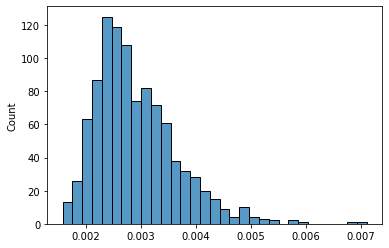

In [79]:
sns.histplot(mmd_dynamic_emp_perm[0, 0])

In [80]:
mmd_dynamic_emp

array([[0.01539993, 0.0171566 , 0.01703835, 0.015522  , 0.01691628],
       [0.01552963, 0.01327515, 0.01036644, 0.01570702, 0.01001549],
       [0.01898003, 0.01965332, 0.01936531, 0.02038765, 0.01769066],
       [0.01471329, 0.01142502, 0.01495934, 0.01292801, 0.01322174],
       [0.01389313, 0.01317215, 0.01189613, 0.01113129, 0.01011276],
       [0.01127434, 0.01164436, 0.01117516, 0.01096916, 0.0109272 ],
       [0.01926422, 0.01959991, 0.01931381, 0.02046013, 0.01986313],
       [0.00994682, 0.01070404, 0.00787735, 0.00862312, 0.011549  ],
       [0.02236938, 0.01710892, 0.01861191, 0.02161407, 0.01885605],
       [0.01504135, 0.01557922, 0.01590919, 0.0144062 , 0.01546478],
       [0.01767921, 0.01229858, 0.01690102, 0.01293755, 0.01342392]],
      dtype=float32)